# Set up

In [1]:
# update path with data dir
import sys
sys.path.append('../../data/')

In [2]:
import warnings
# warnings.filterwarnings('ignore')

In [48]:
import pandas as pd
import patsy
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Getting data

In [4]:
file_name = '../csvs/element_gameweek_features_v03.csv'

In [5]:
element_gameweek_df = pd.read_csv(file_name)

In [6]:
current_event = 20

In [7]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [8]:
element_gameweek_df.fillna(0, inplace=True)

In [9]:
element_gameweek_df.head()

,safe_web_name,element,event,fixture,team,opposition_team,was_home,element_type,value,is_sunday,...,rolling_var_total_points_against_opposition_team_element_type,rolling_avg_total_points_home,rolling_var_total_points_home,rolling_avg_total_points_against_opposition_ground_element_type,rolling_var_total_points_against_opposition_ground_element_type,total_points,expected_avg_total_points_against_opposition_team,expected_var_total_points_against_opposition_team,expected_avg_total_points_at_ground,expected_var_total_points_at_ground
0,cech,1,1,1,1,13,1,1,50,1,...,0.0,0.0,0.0,0.0,0.0,3,0.000000,0.000000,0.000000,0.0
1,cech,1,2,14,1,6,0,1,50,0,...,0.0,0.0,0.0,0.0,0.0,3,0.681818,0.000000,0.000000,0.0
2,cech,1,3,21,1,19,1,1,50,0,...,8.0,3.0,0.0,0.0,0.0,3,3.750000,0.000000,3.000000,0.0
3,cech,1,4,33,1,5,0,1,50,1,...,11.0,3.0,0.0,6.0,0.0,1,4.493304,0.000000,4.901786,0.0
4,cech,1,5,46,1,15,0,1,50,0,...,49.0,3.0,0.0,2.0,0.0,2,3.663651,5.929855,1.332237,0.0


In [10]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [11]:
last_train_event = 15

In [12]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [13]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Building model

In [14]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'rolling_avg_attempted_passes_element',
     'rolling_var_total_points_against_opposition_team',
     'rolling_var_total_points_own_team',
     'rolling_var_total_points_opposition_team',
     'rolling_var_total_points_element_type',
     'rolling_var_total_points_against_opposition_team_element_type',
     'expected_var_total_points_against_opposition_team',
     'expected_var_total_points_at_ground',
     'rolling_avg_total_points_home',
     'rolling_var_total_points_home',
     'rolling_avg_total_points_against_opposition_ground_element_type',
     'rolling_var_total_points_against_opposition_ground_element_type',
     'total_points'
 ]])

In [15]:
print(formula)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + value + is_sunday + is_weekday + is_late + is_early + rolling_avg_total_points_element + rolling_var_total_points_element + rolling_max_total_points_element + rolling_avg_minutes_element_p3 + rolling_avg_bps_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_minutes_element + rolling_avg_clean_sheets_element + rolling_avg_completed_passes_element + rolling_avg_recoveries_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_dribbles_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolli

In [16]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [17]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [44]:
n_features = X.shape[1]

## Tuning model

### GP tuner

In [67]:
space  = [Real(10**-5, 10**-1, "log-uniform", name='learning_rate'),
          Integer(1, 100, name='n_estimators'),
          Integer(1, n_features, name='max_features'),
          Real(10**-2, 10**-1, "log-uniform", name='min_samples_leaf')]

In [68]:
gp_model = GradientBoostingRegressor(criterion='mse', random_state=0)

@use_named_args(space)
def objective(**params):
    gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            gp_model,
            X, y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [69]:
res_gp = gp_minimize(objective, space, n_calls=100, random_state=0)

In [70]:
res_gp.fun

9.395895199395422

In [71]:
res_gp.x

[0.038683941953767044, 69, 358, 0.03791748880599944]

### Grid search

In [72]:
n_estimators = [64, 69, 74]
min_samples_leaf = [.028, 0.038, 0.048]
learning_rate = [0.029, 0.039, 0.049]
max_features = [348, 358, 368]

parameters = {
    'n_estimators': n_estimators,
    'min_samples_leaf': min_samples_leaf,
    'learning_rate': learning_rate,
    'max_features': max_features
}

In [73]:
gs_model = GridSearchCV(
    GradientBoostingRegressor(criterion='mse', random_state=0),
    parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=2)
gs_model.fit(X, y.ravel())

Fitting 1 folds for each of 81 candidates, totalling 81 fits
[CV] learning_rate=0.029, max_features=348, min_samples_leaf=0.028, n_estimators=64 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.029, max_features=348, min_samples_leaf=0.028, n_estimators=64, total=   1.6s
[CV] learning_rate=0.029, max_features=348, min_samples_leaf=0.028, n_estimators=69 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s


[CV]  learning_rate=0.029, max_features=348, min_samples_leaf=0.028, n_estimators=69, total=   1.5s
[CV] learning_rate=0.029, max_features=348, min_samples_leaf=0.028, n_estimators=74 
[CV]  learning_rate=0.029, max_features=348, min_samples_leaf=0.028, n_estimators=74, total=   1.6s
[CV] learning_rate=0.029, max_features=348, min_samples_leaf=0.038, n_estimators=64 
[CV]  learning_rate=0.029, max_features=348, min_samples_leaf=0.038, n_estimators=64, total=   1.4s
[CV] learning_rate=0.029, max_features=348, min_samples_leaf=0.038, n_estimators=69 
[CV]  learning_rate=0.029, max_features=348, min_samples_leaf=0.038, n_estimators=69, total=   1.5s
[CV] learning_rate=0.029, max_features=348, min_samples_leaf=0.038, n_estimators=74 
[CV]  learning_rate=0.029, max_features=348, min_samples_leaf=0.038, n_estimators=74, total=   1.6s
[CV] learning_rate=0.029, max_features=348, min_samples_leaf=0.048, n_estimators=64 
[CV]  learning_rate=0.029, max_features=348, min_samples_leaf=0.048, n_esti

[CV]  learning_rate=0.039, max_features=368, min_samples_leaf=0.028, n_estimators=69, total=   1.5s
[CV] learning_rate=0.039, max_features=368, min_samples_leaf=0.028, n_estimators=74 
[CV]  learning_rate=0.039, max_features=368, min_samples_leaf=0.028, n_estimators=74, total=   1.6s
[CV] learning_rate=0.039, max_features=368, min_samples_leaf=0.038, n_estimators=64 
[CV]  learning_rate=0.039, max_features=368, min_samples_leaf=0.038, n_estimators=64, total=   1.4s
[CV] learning_rate=0.039, max_features=368, min_samples_leaf=0.038, n_estimators=69 
[CV]  learning_rate=0.039, max_features=368, min_samples_leaf=0.038, n_estimators=69, total=   1.5s
[CV] learning_rate=0.039, max_features=368, min_samples_leaf=0.038, n_estimators=74 
[CV]  learning_rate=0.039, max_features=368, min_samples_leaf=0.038, n_estimators=74, total=   1.5s
[CV] learning_rate=0.039, max_features=368, min_samples_leaf=0.048, n_estimators=64 
[CV]  learning_rate=0.039, max_features=368, min_samples_leaf=0.048, n_esti

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  2.0min finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=GradientBoostingRegressor(alpha=0.9, criterion='mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,...
                                                 subsample=1.0, tol=0.0001,
                                                 validation_fraction=0.1,
         

In [75]:
gs_model_df = pd.DataFrame(gs_model.cv_results_)[[
    'param_n_estimators','param_min_samples_leaf','param_learning_rate','param_max_features',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]
gs_model_df

,param_n_estimators,param_min_samples_leaf,param_learning_rate,param_max_features,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,64,0.028,0.029,348,-2.196979,-9.440739
1,69,0.028,0.029,348,-2.195393,-9.440306
2,74,0.028,0.029,348,-2.195763,-9.438275
3,64,0.038,0.029,348,-2.202228,-9.451630
4,69,0.038,0.029,348,-2.199899,-9.449654
5,74,0.038,0.029,348,-2.198757,-9.440924
6,64,0.048,0.029,348,-2.202961,-9.473933
7,69,0.048,0.029,348,-2.199384,-9.455482
8,74,0.048,0.029,348,-2.197725,-9.448188
9,64,0.028,0.029,358,-2.197357,-9.439963


In [76]:
gs_model_df[
    gs_model_df['split0_test_neg_mean_squared_error'] == \
    gs_model_df['split0_test_neg_mean_squared_error'].max()]


,param_n_estimators,param_min_samples_leaf,param_learning_rate,param_max_features,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
46,69,0.028,0.039,368,-2.180896,-9.379271


# Evaluating model

In [77]:
model = GradientBoostingRegressor(
    n_estimators=69, min_samples_leaf=0.028, learning_rate=0.039, max_features=368,
    criterion='mse', random_state=0)
model.fit(X_train, y_train.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.039, loss='ls', max_depth=3,
                          max_features=368, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=0.028, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=69,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [78]:
# get predictions for test set
y_pred = model.predict(X_test).flatten()

# calculate cross entropy loss for test set
test_loss = (mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred))
test_loss

(2.1808961583839754, 9.379271371210882)

In [79]:
pd.Series(y_pred).describe()

count    948.000000
mean       2.700595
std        0.830098
min        1.240172
25%        2.089869
50%        2.580462
75%        3.144960
max        6.185113
dtype: float64

In [81]:
# refit model on all data
model_full = GradientBoostingRegressor(
    n_estimators=69, min_samples_leaf=0.028, learning_rate=0.039, max_features=368,
    criterion='mse', random_state=0)
model_full.fit(X, y.ravel())

GradientBoostingRegressor(alpha=0.9, criterion='mse', init=None,
                          learning_rate=0.039, loss='ls', max_depth=3,
                          max_features=368, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=0.028, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=69,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=1.0, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [82]:
# get predictions for whole set
y_pred_full = model_full.predict(X).flatten()

# calculate cross entropy loss for test set
test_loss_full = (mean_absolute_error(y, y_pred_full), mean_squared_error(y, y_pred_full))
test_loss_full

(2.086574866604868, 8.154317776571567)

In [83]:
pd.Series(y_pred_full).describe()

count    3644.000000
mean        2.869374
std         0.853316
min         1.279665
25%         2.227946
50%         2.783808
75%         3.323709
max         6.691393
dtype: float64

In [84]:
abs(pd.Series(y.ravel()) - pd.Series(y_pred_full)).describe()

count    3644.000000
mean        2.086575
std         1.949761
min         0.000806
25%         0.816839
50%         1.634461
75%         2.696277
max        14.739865
dtype: float64

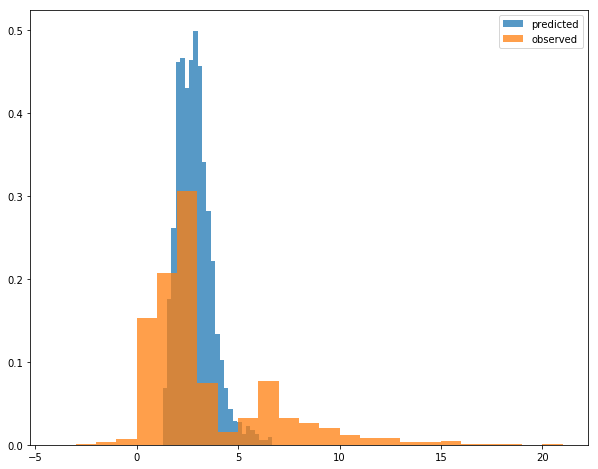

In [85]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(y_pred_full), bins=25, alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y.ravel()), bins=25, alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

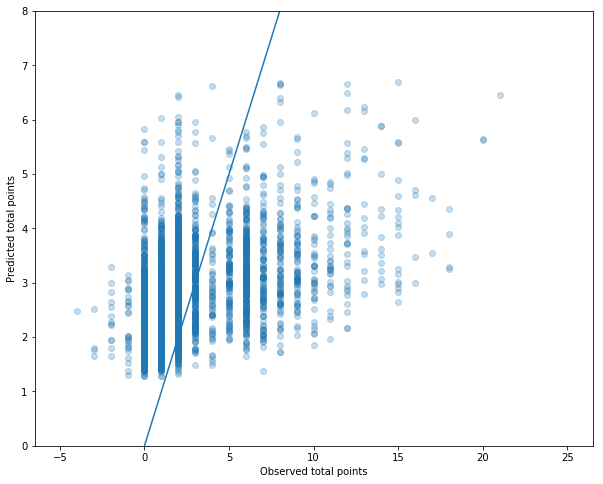

In [87]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y.ravel()), pd.Series(y_pred_full), alpha=0.25)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((0, 8))
plt.show()